In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import json

info_res_df = pd.read_csv("info_residencias.csv")
info_pets_df = pd.read_csv("info_pets.csv")
infos_df = pd.merge(info_pets_df, info_res_df, on="id_residencia", how="left")

In [2]:
# Estilo
CORES = {
    'Cachorro': '#ffa500',
    'Gato': '#FF6B6B',
    'Pássaro': '#FFD166',
    'Sim': '#118AB2',
    'Não': '#ffa500',
    'Campanha pública': '#118AB2',
    'Clínica veterinária': '#073B4C',
    'Raiva': '#006691',
    'Não informado': '#94e7ff',
    'Não especificado': '#2499c7',
    'Outro': '#40cfff',
    'Bordô': '#056a9a',
}

CONFIG_GRAFICOS = {
    'titulo_fontsize': 13,
    'titulo_fontweight': 'bold',
    'label_fontsize': 10,
    'ticks_fontsize': 9,
    'grid_alpha': 0.2,
    'bar_width': 0.5,
}

def configurar_grafico(ax, titulo, ylabel='', tem_texto_topo=False):
    ax.set_title(titulo, fontsize=CONFIG_GRAFICOS['titulo_fontsize'], 
                 fontweight=CONFIG_GRAFICOS['titulo_fontweight'], pad=12)
    ax.set_ylabel(ylabel, fontsize=CONFIG_GRAFICOS['label_fontsize'])
    ax.grid(axis='y', alpha=CONFIG_GRAFICOS['grid_alpha'])
    ax.tick_params(axis='both', labelsize=CONFIG_GRAFICOS['ticks_fontsize'])
    
    if tem_texto_topo:
        ymin, ymax = ax.get_ylim()
        ax.set_ylim(ymin, ymax * 1.15)

In [3]:
# função pra dados por bairro
def calcular_dados_bairro(bairro_nome):
    res_bairro = info_res_df[info_res_df['bairro'] == bairro_nome]
    pets_bairro = info_pets_df.merge(res_bairro, on='id_residencia')
    
    casas = res_bairro['id_residencia'].nunique()
    casas_com_pets = res_bairro[res_bairro['possui_pet'] == 'Sim']['id_residencia'].nunique()
    pessoas = res_bairro[res_bairro['possui_pet'] == 'Sim']['qtd_pessoas'].sum()
    pets_total = pets_bairro['id_pet'].nunique()
    
    if pets_total > 0:
        pets_vacinados = (pets_bairro['vacinado'] == 'Sim').sum()
        percentual_vacinados = pets_vacinados / pets_total * 100
    else:
        percentual_vacinados = 0
    
    especie_pred = pets_bairro['especie'].mode()
    especie_pred_nome = especie_pred[0] if not especie_pred.empty else "Nenhuma"
    
    return {
        'casas': int(casas),
        'casas_com_pets': int(casas_com_pets),
        'pessoas': int(pessoas),
        'pets': int(pets_total),
        'percentual_vacinados': float(f"{percentual_vacinados:.1f}"),
        'especie_predominante': especie_pred_nome,
        'pets_df': pets_bairro
    }

In [4]:
# dados da cidade
total_casas = info_res_df['id_residencia'].nunique()
casas_com_pets = info_res_df[info_res_df['possui_pet'] == 'Sim']['id_residencia'].nunique()
pessoas_casas_com_pets = info_res_df[info_res_df['possui_pet'] == 'Sim']['qtd_pessoas'].sum()
total_pets = info_pets_df['id_pet'].nunique()

pets_vacinados_cidade = (info_pets_df['vacinado'] == 'Sim').sum()
percentual_vacinados_cidade = (pets_vacinados_cidade / total_pets * 100) if total_pets > 0 else 0

especie_pred_cidade = info_pets_df['especie'].mode()
especie_pred_cidade_nome = especie_pred_cidade[0] if not especie_pred_cidade.empty else "Nenhuma"

dados_cidade = {
    'total_casas': int(total_casas),
    'casas_com_pets': int(casas_com_pets),
    'pessoas_afetadas': int(pessoas_casas_com_pets),
    'total_pets': int(total_pets),
    'percentual_vacinados': float(f"{percentual_vacinados_cidade:.1f}"),
    'especie_predominante': especie_pred_cidade_nome
}

In [5]:
# dados por bairro
bairros = info_res_df['bairro'].unique()
dados_bairros = {}
for bairro in bairros:
    dados_bairros[bairro] = calcular_dados_bairro(bairro)

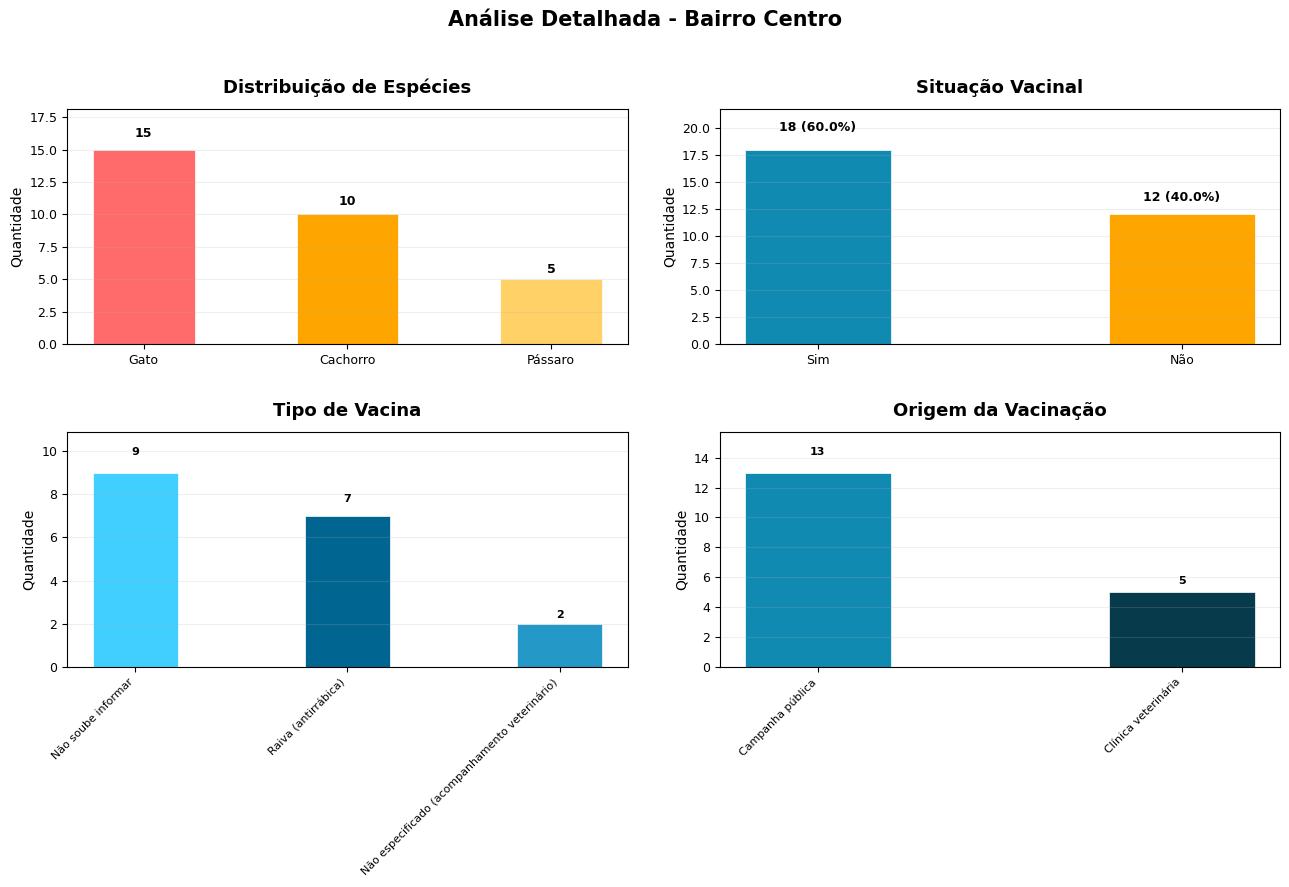

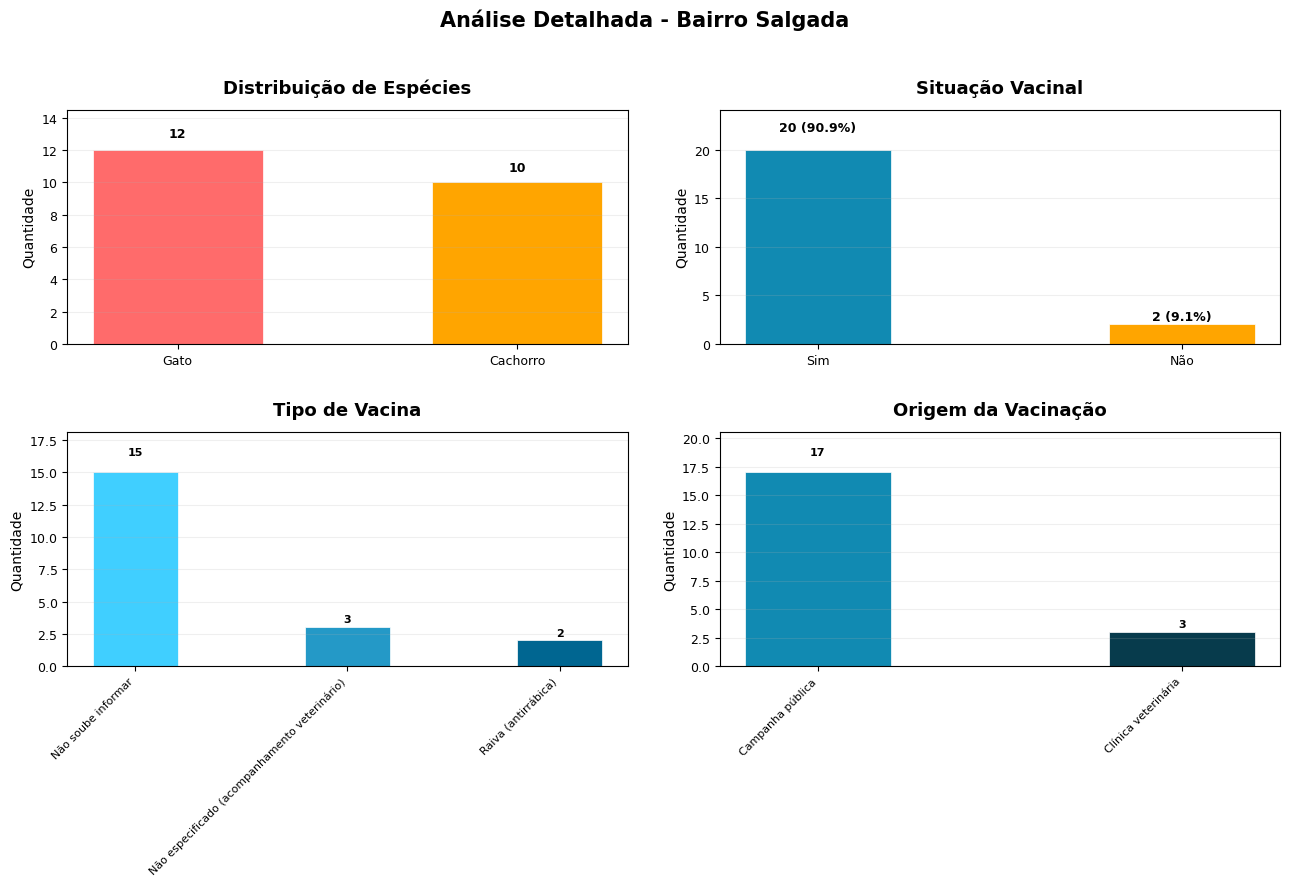

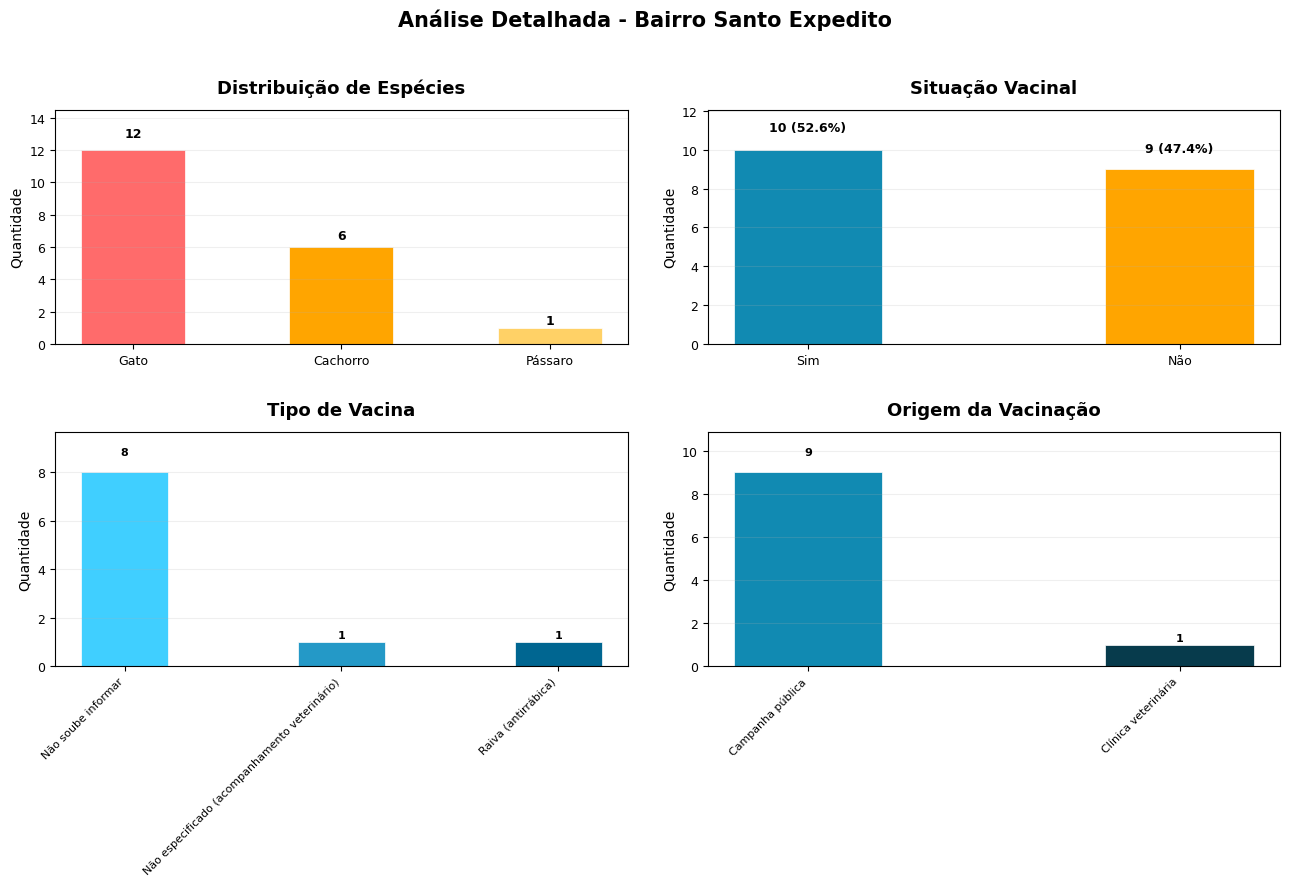

In [9]:
# grafico de cada bairro
def gerar_graficos_bairro(bairro_nome, salvar_imagem=False):
    dados = calcular_dados_bairro(bairro_nome)
    pets_bairro = dados['pets_df']
    fig, axes = plt.subplots(2, 2, figsize=(13, 9))
    fig.suptitle(f'Análise Detalhada - Bairro {bairro_nome}', 
                 fontsize=15, fontweight='bold', y=0.98)
    
    # Gráfico 1:Espécies
    ax1 = axes[0, 0]
    especies_counts = pets_bairro['especie'].value_counts()
    
    barras_especies = ax1.bar(especies_counts.index, especies_counts.values, 
                             width=CONFIG_GRAFICOS['bar_width'])
    
    for especie, barra in zip(especies_counts.index, barras_especies):
        barra.set_color(CORES.get(especie, '#999999'))
        barra.set_edgecolor('white')
        barra.set_linewidth(0.5)
    
    configurar_grafico(ax1, 'Distribuição de Espécies', 'Quantidade', tem_texto_topo=True)
    
    for barra in barras_especies:
        altura = barra.get_height()
        ax1.text(barra.get_x() + barra.get_width()/2, altura + (altura * 0.05),
                f'{int(altura)}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # Gráfico 2: Vacinação
    ax2 = axes[0, 1]
    vacinados_counts = pets_bairro['vacinado'].value_counts()  
    cores_vacinacao = [CORES['Sim'] if status == 'Sim' else CORES['Não'] 
                      for status in vacinados_counts.index]
    
    barras_vacinacao = ax2.bar(vacinados_counts.index, vacinados_counts.values,
                              width=CONFIG_GRAFICOS['bar_width'] * 0.8,
                              color=cores_vacinacao)
    
    for barra in barras_vacinacao:
        barra.set_edgecolor('white')
        barra.set_linewidth(0.5)  
    configurar_grafico(ax2, 'Situação Vacinal', 'Quantidade', tem_texto_topo=True)
    
    total_pets = len(pets_bairro)
    for barra in barras_vacinacao:
        altura = barra.get_height()
        percentual = (altura / total_pets) * 100
        ax2.text(barra.get_x() + barra.get_width()/2, altura + (altura * 0.08),
                f'{int(altura)} ({percentual:.1f}%)', 
                ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # Gráfico 3: Tipo de Vacina
    ax3 = axes[1, 0]
    vacinados_df = pets_bairro[pets_bairro['vacinado'] == 'Sim']
    
    if not vacinados_df.empty:
        vacinas_counts = vacinados_df['vacinas'].value_counts(dropna=False)
        vacinas_counts = vacinas_counts.rename({None: 'Não informado'})
        
        cores_vacinas = []
        for vacina in vacinas_counts.index:
            vacina_str = str(vacina)
            if 'Raiva' in vacina_str:
                cores_vacinas.append(CORES['Raiva'])
            elif 'Não informado' in vacina_str:
                cores_vacinas.append(CORES['Não informado'])
            elif 'Não especificado' in vacina_str:
                cores_vacinas.append(CORES['Não especificado'])
            else:
                cores_vacinas.append(CORES['Outro'])
        
        x_pos = list(range(len(vacinas_counts)))
        barras_vacinas = ax3.bar(x_pos, vacinas_counts.values,
                                width=CONFIG_GRAFICOS['bar_width'] * 0.8,
                                color=cores_vacinas)
        
        for barra in barras_vacinas:
            barra.set_edgecolor('white')
            barra.set_linewidth(0.5)
        
        configurar_grafico(ax3, 'Tipo de Vacina', 'Quantidade', tem_texto_topo=True)
        ax3.set_xticks(x_pos)
        ax3.set_xticklabels(vacinas_counts.index, rotation=45, ha='right', fontsize=8)
        
        for barra in barras_vacinas:
            altura = barra.get_height()
            ax3.text(barra.get_x() + barra.get_width()/2, altura + (altura * 0.08),
                    f'{int(altura)}', ha='center', va='bottom', fontsize=8, fontweight='bold')
    else:
        ax3.text(0.5, 0.5, 'Nenhum pet vacinado\nneste bairro',
                ha='center', va='center', transform=ax3.transAxes,
                fontsize=10, style='italic', color='#666666')
        configurar_grafico(ax3, 'Tipo de Vacina', 'Quantidade')
        ax3.grid(False)
    
    # Gráfico 4: Origem
    ax4 = axes[1, 1]
    
    if not vacinados_df.empty and 'origem_vacina' in vacinados_df.columns:
        origem_counts = vacinados_df['origem_vacina'].value_counts(dropna=False)
        origem_counts = origem_counts.rename({None: 'Não informado'})
        
        cores_origem = []
        for origem in origem_counts.index:
            origem_str = str(origem)
            if 'Campanha' in origem_str:
                cores_origem.append(CORES['Campanha pública'])
            elif 'Clínica' in origem_str:
                cores_origem.append(CORES['Clínica veterinária'])
            elif 'Não informado' in origem_str:
                cores_origem.append(CORES['Não informado'])
            else:
                cores_origem.append(CORES['Bordô'])
        
        x_pos = list(range(len(origem_counts)))
        barras_origem = ax4.bar(x_pos, origem_counts.values,
                               width=CONFIG_GRAFICOS['bar_width'] * 0.8,
                               color=cores_origem)
        
        for barra in barras_origem:
            barra.set_edgecolor('white')
            barra.set_linewidth(0.5)
        
        configurar_grafico(ax4, 'Origem da Vacinação', 'Quantidade', tem_texto_topo=True)
        ax4.set_xticks(x_pos)
        ax4.set_xticklabels(origem_counts.index, rotation=45, ha='right', fontsize=8)
        
        for barra in barras_origem:
            altura = barra.get_height()
            ax4.text(barra.get_x() + barra.get_width()/2, altura + (altura * 0.08),
                    f'{int(altura)}', ha='center', va='bottom', fontsize=8, fontweight='bold')
    else:
        ax4.text(0.5, 0.5, 'Sem dados de origem\nda vacinação',
                ha='center', va='center', transform=ax4.transAxes,
                fontsize=10, style='italic', color='#666666')
        configurar_grafico(ax4, 'Origem da Vacinação', 'Quantidade')
        ax4.grid(False)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96], h_pad=2.5, w_pad=2.5)
    
    if salvar_imagem:
        nome_arquivo = f'grafico_{bairro_nome.replace(" ", "_")}.png'
        plt.savefig(nome_arquivo, dpi=150, bbox_inches='tight')

    plt.show()
    return dados

    # CÉLULA 8: GERAR GRÁFICOS PARA TODOS OS BAIRROS
for bairro in bairros:
    gerar_graficos_bairro(bairro, salvar_imagem=True)

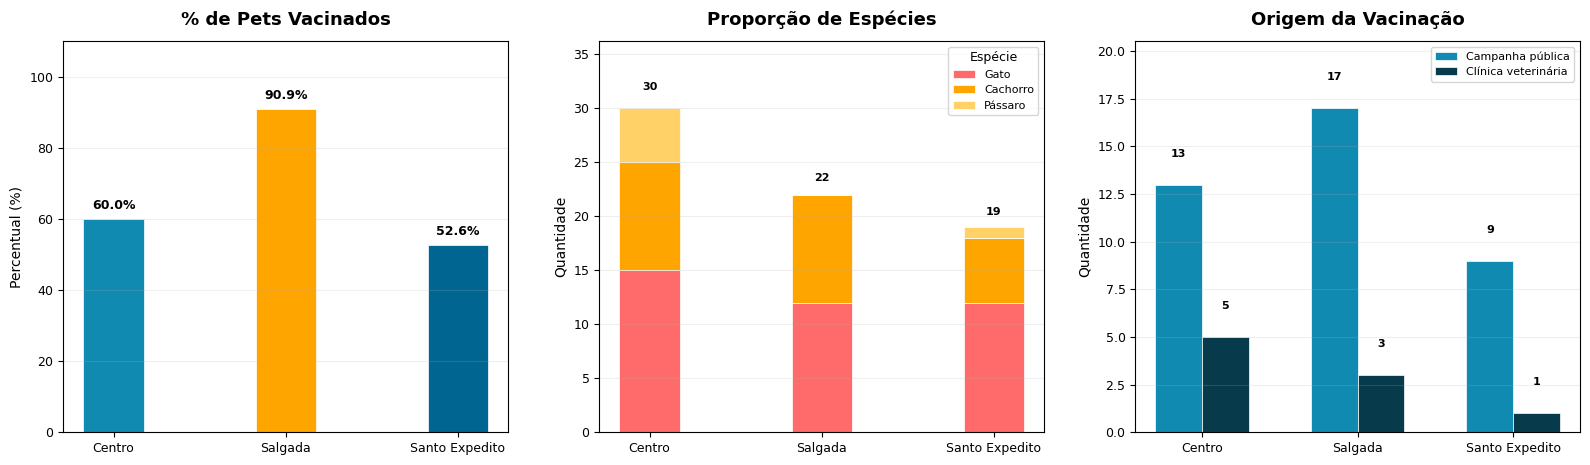

In [7]:
# graficos da cidade
def gerar_graficos_comparativos():
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    
    # Gráfico 1: % Vacinados
    ax1 = axes[0]
    percentuais = [dados_bairros[b]['percentual_vacinados'] for b in bairros]
    
    barras1 = ax1.bar(bairros, percentuais, 
                     width=CONFIG_GRAFICOS['bar_width'] * 0.7,
                     color=['#118AB2', '#ffa500', '#006691'])
    
    for barra in barras1:
        barra.set_edgecolor('white')
        barra.set_linewidth(0.5)
    
    configurar_grafico(ax1, '% de Pets Vacinados', 'Percentual (%)', tem_texto_topo=True)
    ax1.set_ylim(0, 110)
    
    for barra in barras1:
        altura = barra.get_height()
        ax1.text(barra.get_x() + barra.get_width()/2, altura + 2,
                f'{altura:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # Gráfico 2: Espécies
    ax2 = axes[1]
    
    especies_todas = []
    for bairro in bairros:
        pets_bairro = calcular_dados_bairro(bairro)['pets_df']
        especies_counts = pets_bairro['especie'].value_counts()
        especies_todas.append(especies_counts)
    
    df_especies = pd.DataFrame(especies_todas, index=bairros).fillna(0)
    
    bottom = [0] * len(bairros)
    
    for especie in df_especies.columns:
        valores = df_especies[especie].tolist()
        ax2.bar(bairros, valores, bottom=bottom, 
               label=especie, color=CORES.get(especie, '#999999'),
               width=CONFIG_GRAFICOS['bar_width'] * 0.7,
               edgecolor='white', linewidth=0.5)
        
        for i in range(len(bairros)):
            bottom[i] += valores[i]
    
    configurar_grafico(ax2, 'Proporção de Espécies', 'Quantidade', tem_texto_topo=True)
    ax2.legend(title='Espécie', fontsize=8, title_fontsize=9, loc='upper right')
    
    totais = df_especies.sum(axis=1).tolist()
    for i, total in enumerate(totais):
        ax2.text(i, total + (total * 0.05), f'{int(total)}', 
                ha='center', va='bottom', fontsize=8, fontweight='bold')
    
    # Gráfico 3: Origem
    ax3 = axes[2]
    
    origens = ['Campanha pública', 'Clínica veterinária']
    dados_origem = {origem: [] for origem in origens}
    
    for bairro in bairros:
        pets_bairro = calcular_dados_bairro(bairro)['pets_df']
        vacinados_bairro = pets_bairro[pets_bairro['vacinado'] == 'Sim']
        
        for origem in origens:
            count = vacinados_bairro[vacinados_bairro['origem_vacina'] == origem].shape[0]
            dados_origem[origem].append(count)
    
    x = list(range(len(bairros)))
    largura = 0.3
    
    barras_campanha = ax3.bar([pos - largura/2 for pos in x], dados_origem['Campanha pública'], 
                             largura, label='Campanha pública', 
                             color=CORES['Campanha pública'],
                             edgecolor='white', linewidth=0.5)
    
    barras_clinica = ax3.bar([pos + largura/2 for pos in x], dados_origem['Clínica veterinária'], 
                            largura, label='Clínica veterinária', 
                            color=CORES['Clínica veterinária'],
                            edgecolor='white', linewidth=0.5)
    
    configurar_grafico(ax3, 'Origem da Vacinação', 'Quantidade', tem_texto_topo=True)
    ax3.set_xticks(x)
    ax3.set_xticklabels(bairros)
    ax3.legend(fontsize=8, loc='upper right')
    
    max_campanha = max(dados_origem['Campanha pública'])
    max_clinica = max(dados_origem['Clínica veterinária'])
    max_valor = max(max_campanha, max_clinica)
    offset = max_valor * 0.08 if max_valor > 0 else 0.5
    
    for barra in barras_campanha:
        altura = barra.get_height()
        if altura > 0:
            ax3.text(barra.get_x() + barra.get_width()/2, altura + offset,
                    f'{int(altura)}', ha='center', va='bottom', fontsize=8, fontweight='bold')
    
    for barra in barras_clinica:
        altura = barra.get_height()
        if altura > 0:
            ax3.text(barra.get_x() + barra.get_width()/2, altura + offset,
                    f'{int(altura)}', ha='center', va='bottom', fontsize=8, fontweight='bold')
    
    plt.tight_layout(rect=[0, 0, 1, 0.95], w_pad=2.0)
    plt.savefig('grafico_comparativo_cidade.png', dpi=150, bbox_inches='tight')
    plt.show()
    

gerar_graficos_comparativos()